In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import os
import warnings
warnings.filterwarnings('ignore')

# Generate Data Matrix

In [2]:
number_of_persons = 40

In [3]:
def read_single_image(image_path):
    ans = []
    with open(image_path, 'rb') as f:
        for i in range(10304):
            ans.append(ord(f.read(1)))
    return ans
    
def construct_data_frame():
    
    images = []
    persons = []
    
    path = r'C:\Users\Abdelrahman\Face Recognition Dataset\s'
    print('Reading Started')
    for x in range(1, number_of_persons + 1):
        current_person_path = path + str(x) + '/'
        for y in range(1, 11):
            persons.append(str(x))
            images.append(read_single_image(current_person_path + str(y) + '.pgm'))
    print('Reading Finished')
    
    print(len(images))
    print(len(images[0]))
    print(len(persons))
    
    images = np.array(images)
   
    return images, persons
            
(D, labels) = construct_data_frame()

Reading Started
Reading Finished
400
10304
400


# Train-Test Split

In [4]:
def custom_train_test_split(data, labels, samples_no, train_indices):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(samples_no):
        if i%10 in train_indices:
            X_train.append(data[i])
            y_train.append(labels[i])
        else:
            X_test.append(data[i])
            y_test.append(labels[i])
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = custom_train_test_split(D, labels, len(D), [0, 2, 4, 6, 8])
train_data = pd.DataFrame(X_train,index=y_train)

In [5]:
def train_test_split(data, labels, samples_no, train_indices):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    count=1
    for i in range(samples_no):
        if count>=10:
            X_train.append(data[i])
            y_train.append(labels[i])
        if count<=3:
            X_test.append(data[i])
            y_test.append(labels[i])
        count+=1
        if count  == 11:
            count = 0
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = train_test_split(D, labels, len(D), [0, 2, 4, 6, 8])
train_data = pd.DataFrame(X_train,index=y_train)

In [6]:
def classify(X_train, y_train, X_test, y_test, n_neighbors, confusion_matrix_needed=False):
    simple_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    simple_classifier.fit(X_train, y_train)
    test_samples = len(X_test)
    acc = 0
    y_predict = []
    for i in range(test_samples):
        result = simple_classifier.predict([X_test[i]])
        y_predict.append(result)
        if result == y_test[i]:
            acc += 1
        
    acc /= test_samples
    print(f'Acc at K = {n_neighbors}: {acc*100} %')
    if confusion_matrix_needed:
        conf_matrix = confusion_matrix(y_test, y_predict)
        return conf_matrix, acc
    return acc

# PCA

**Calculating mean**

In [7]:
def calculate_mean(data):
    return np.mean(data)

**Centralize data**

In [8]:
def centeralize(data):
    return data - calculate_mean(data)

**Covariance Matrix**

In [9]:
def calculate_covariance_matrix(data):
    z = centeralize(data)
    return (np.matmul(np.transpose(z), z)) / len(data)

**Eigen values, Eigen vectors**

In [10]:
def calculate_eigen_vectors(data):
    cov = calculate_covariance_matrix(data)
    eig_values, eig_vectors = np.linalg.eigh(cov)
    idx = eig_values.argsort()[::-1]   
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]
    return eig_values, eig_vectors

**Choosing dimensionality**

In [11]:
def dimensionality(alpha, eig_values):
    sum = np.sum(eig_values)
    r = 0
    i = 0
    for value in eig_values: 
        r = r + eig_values[i]
        i = i + 1
        if (r / sum >= alpha):
            break
    return i

In [12]:
def calculate_reduced_dimensions(alpha_values, eig_values):
    reduced_dimensions = []
    for alpha in alpha_values:
        reduced_dimensions.append(dimensionality(alpha, eig_values))
    return reduced_dimensions

# **KNN and KNN tuning for different alpha values**

In [13]:
def PCA(data, alpha_values):
    eig_values, eig_vectors = calculate_eigen_vectors(data)
    r = calculate_reduced_dimensions(alpha_values, eig_values)
    return r, eig_vectors

Acc at K = 1: 59.183673469387756 %
Acc at K = 3: 29.25170068027211 %
Acc at K = 5: 21.768707482993197 %
Acc at K = 7: 16.3265306122449 %


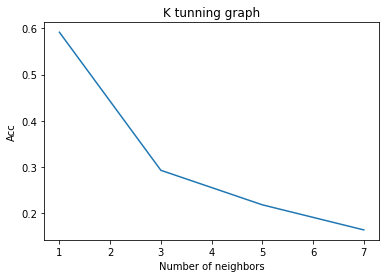

Acc at K = 1: 58.50340136054422 %
Acc at K = 3: 29.25170068027211 %
Acc at K = 5: 21.08843537414966 %
Acc at K = 7: 14.965986394557824 %


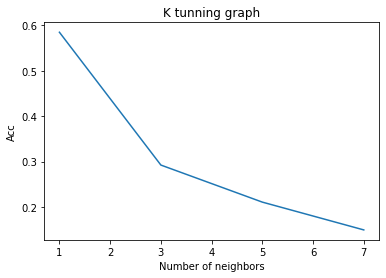

Acc at K = 1: 57.14285714285714 %
Acc at K = 3: 27.89115646258503 %
Acc at K = 5: 21.768707482993197 %
Acc at K = 7: 16.3265306122449 %


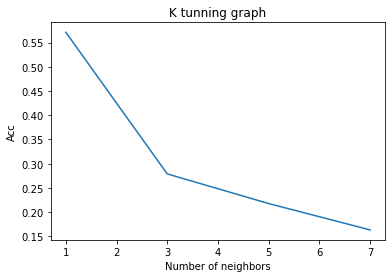

Acc at K = 1: 57.82312925170068 %
Acc at K = 3: 29.931972789115648 %
Acc at K = 5: 23.12925170068027 %
Acc at K = 7: 14.965986394557824 %


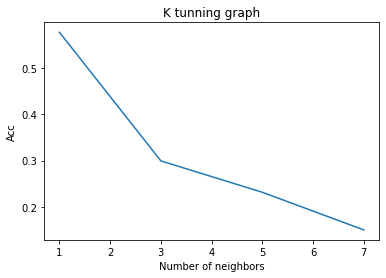

In [14]:
mean = calculate_mean(train_data)
z = centeralize(train_data)
r, eig_vectors = PCA(train_data, [0.8, 0.85, 0.9, 0.95])
for i in r:
    U = eig_vectors[:,0:i].T
    projected_train_data = np.array(np.matmul(z, U.T))
    projected_test_data = np.array(np.matmul(X_test - np.array(mean), U.T))
    acc = []
    k_values = [1, 3, 5, 7]
    for k in k_values:
        acc.append(classify(projected_train_data, y_train, projected_test_data, y_test, k))

    plt.plot(k_values, acc)
    plt.xlabel('Number of neighbors')
    plt.ylabel('Acc')
    plt.title('K tunning graph')
    plt.show()